# Elastic full-waveform inversion on part of Marmousi2 model
### the module 'segyio' is required to be able to read segy files

In [1]:
# install segyio package if necessary
#!pip install segyio

In [2]:
import numpy as np
from scipy import signal
import math
import segyio
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
!mkdir -p ../dat ../fig

### Generate source wavelet (Ricker)

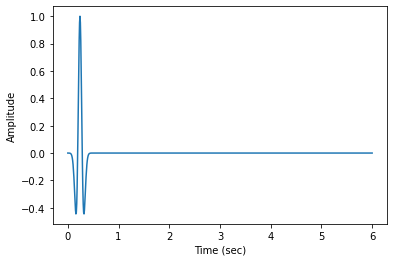

In [4]:
nt=751
dt=0.008
ot=0
wc=0.08
sigma=math.sqrt(2)/(math.pi*wc)
src= signal.ricker(2*nt-1, sigma)
src=src[720:720+nt]
src=src*1.0/np.max(src)

plt.plot(np.linspace(ot,(nt-1)*dt,nt),src)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.show()

In [5]:
# save to numpy
np.save('../dat/src2',src)

# convert to SEPlib for FWI
!sep2numpy.py --input ../dat/src2.npy --mode 1 --datapath ${PWD}/../dat/ --output ../dat/src2.H

# set the sampling (in sec) in the description file
!echo d1=0.008 >> ../dat/src2.H

### Download Marmousi2 model (it may take a couple of minutes)

In [6]:
!wget https://s3.amazonaws.com/open.source.geoscience/open_data/elastic-marmousi/elastic-marmousi-model.tar.gz -P ../dat/
!tar -xvf ../dat/elastic-marmousi-model.tar.gz -C ../dat/
!rm -rf ../dat/elastic-marmousi-model.tar.gz
!tar -xvf ../dat/elastic-marmousi-model/model/MODEL_P-WAVE_VELOCITY_1.25m.segy.tar.gz -C ../dat/elastic-marmousi-model/model/
!tar -xvf ../dat/elastic-marmousi-model/model/MODEL_S-WAVE_VELOCITY_1.25m.segy.tar.gz -C ../dat/elastic-marmousi-model/model/
!tar -xvf ../dat/elastic-marmousi-model/model/MODEL_DENSITY_1.25m.segy.tar.gz -C ../dat/elastic-marmousi-model/model/

--2022-04-01 10:51:47--  https://s3.amazonaws.com/open.source.geoscience/open_data/elastic-marmousi/elastic-marmousi-model.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.112.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.112.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153722387 (147M) [application/x-gzip]
Saving to: ‘../dat/elastic-marmousi-model.tar.gz’

100%[======================================>] 153,722,387 14.9MB/s   in 10s    

2022-04-01 10:52:00 (14.0 MB/s) - ‘../dat/elastic-marmousi-model.tar.gz’ saved [153722387/153722387]

elastic-marmousi-model/model/
elastic-marmousi-model/processed_data/SEGY-Time/Kirchhoff_PoSTM_time.segy.tar.gz
elastic-marmousi-model/processed_data/SEGY-Time/SYNTHETIC_time.segy.tar.gz
elastic-marmousi-model/model/LAYER_PROPERTIES.pdf
elastic-marmousi-model/processed_data/SEGY-Depth/SYNTHETIC.segy.tar.gz
elastic-marmousi-model/processed_data/
elastic-marmousi-model/processed_data/SEGY-Depth/Ki

In [7]:
# read segy to numpy

with segyio.open("../dat/elastic-marmousi-model/model/MODEL_P-WAVE_VELOCITY_1.25m.segy",ignore_geometry=False) as f:
    nt=len(f.samples)
    ntr=f.tracecount
    vp=np.zeros((ntr,nt))
    for i in range(ntr):
        vp[i,:]=f.trace[i]      
        
with segyio.open("../dat/elastic-marmousi-model/model/MODEL_S-WAVE_VELOCITY_1.25m.segy",ignore_geometry=False) as f:
    nt=len(f.samples)
    ntr=f.tracecount
    vs=np.zeros((ntr,nt))
    for i in range(ntr):
        vs[i,:]=f.trace[i]
        
with segyio.open("../dat/elastic-marmousi-model/model/MODEL_DENSITY_1.25m.segy",ignore_geometry=False) as f:
    nt=len(f.samples)
    ntr=f.tracecount
    rho=np.zeros((ntr,nt))
    for i in range(ntr):
        rho[i,:]=f.trace[i]

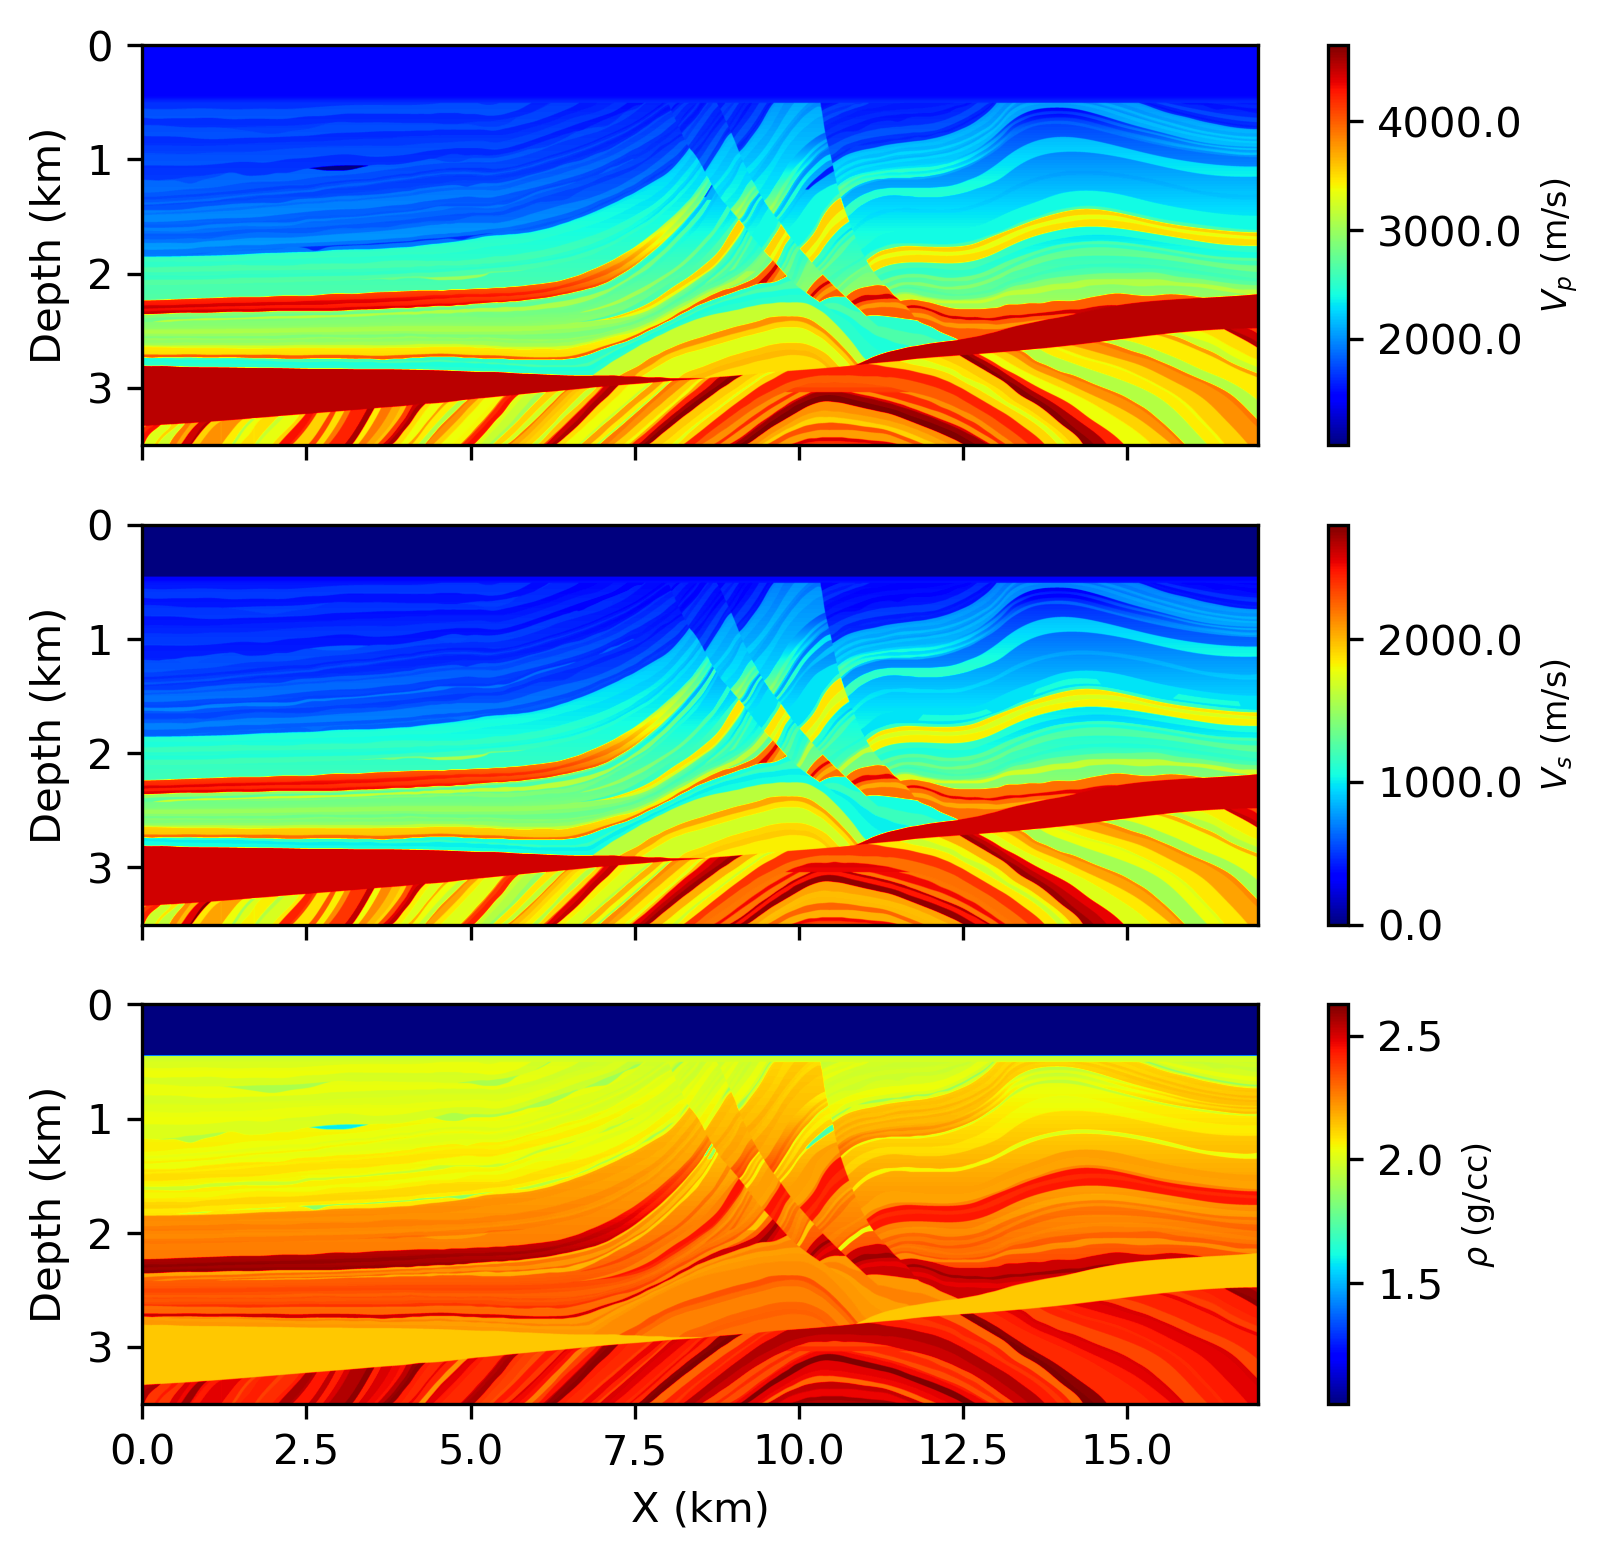

In [8]:
# plot the full Marmousi2 model, sampled 1.25 x 1.25 m, 17 km wide, 3.5 km deep

fig, ax = plt.subplots(3,1,figsize=(6, 6),dpi=300)
im0=ax[0].imshow(np.transpose(vp),interpolation='bilinear',aspect="auto",extent=[0,17,3.5,0],cmap='jet')
im1=ax[1].imshow(np.transpose(vs),interpolation='bilinear',aspect="auto",extent=[0,17,3.5,0],cmap='jet')
im2=ax[2].imshow(np.transpose(rho),interpolation='bilinear',aspect="auto",extent=[0,17,3.5,0],cmap='jet')
ax[0].set(ylabel='Depth (km)')
ax[1].set(ylabel='Depth (km)')
ax[2].set(xlabel='X (km)',ylabel='Depth (km)')
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
cbar0=fig.colorbar(im0, ax=ax[0],format='%.'+str(1)+'f',aspect=20)
cbar1=fig.colorbar(im1, ax=ax[1],format='%.'+str(1)+'f',aspect=20)
cbar2=fig.colorbar(im2, ax=ax[2],format='%.'+str(1)+'f',aspect=20)
cbar0.set_label(label=r'$V_p$ (m/s)',size=8)
cbar1.set_label(label=r'$V_s$ (m/s)',size=8)
cbar2.set_label(label=r'$\rho$ (g/cc)',size=8)

### Cut a chunk and smooth the Marmousi2 model, and prepare inputs for FWI

In [9]:
# cut a chunk of the model and decimate from 1.25 to 12.5 m sampling in X and Z
# remove water layer as it will be added implicitly during modeling and inversion
# convert units to km/s
vpcut=vp[:,np.arange(361,2002,10)]
vpcut=0.001*vpcut[np.arange(5600,12001,10),:]
vscut=vs[:,np.arange(361,2002,10)]
vscut=0.001*vscut[np.arange(5600,12001,10),:]
rhocut=rho[:,np.arange(361,2002,10)]
rhocut=rhocut[np.arange(5600,12001,10),:]

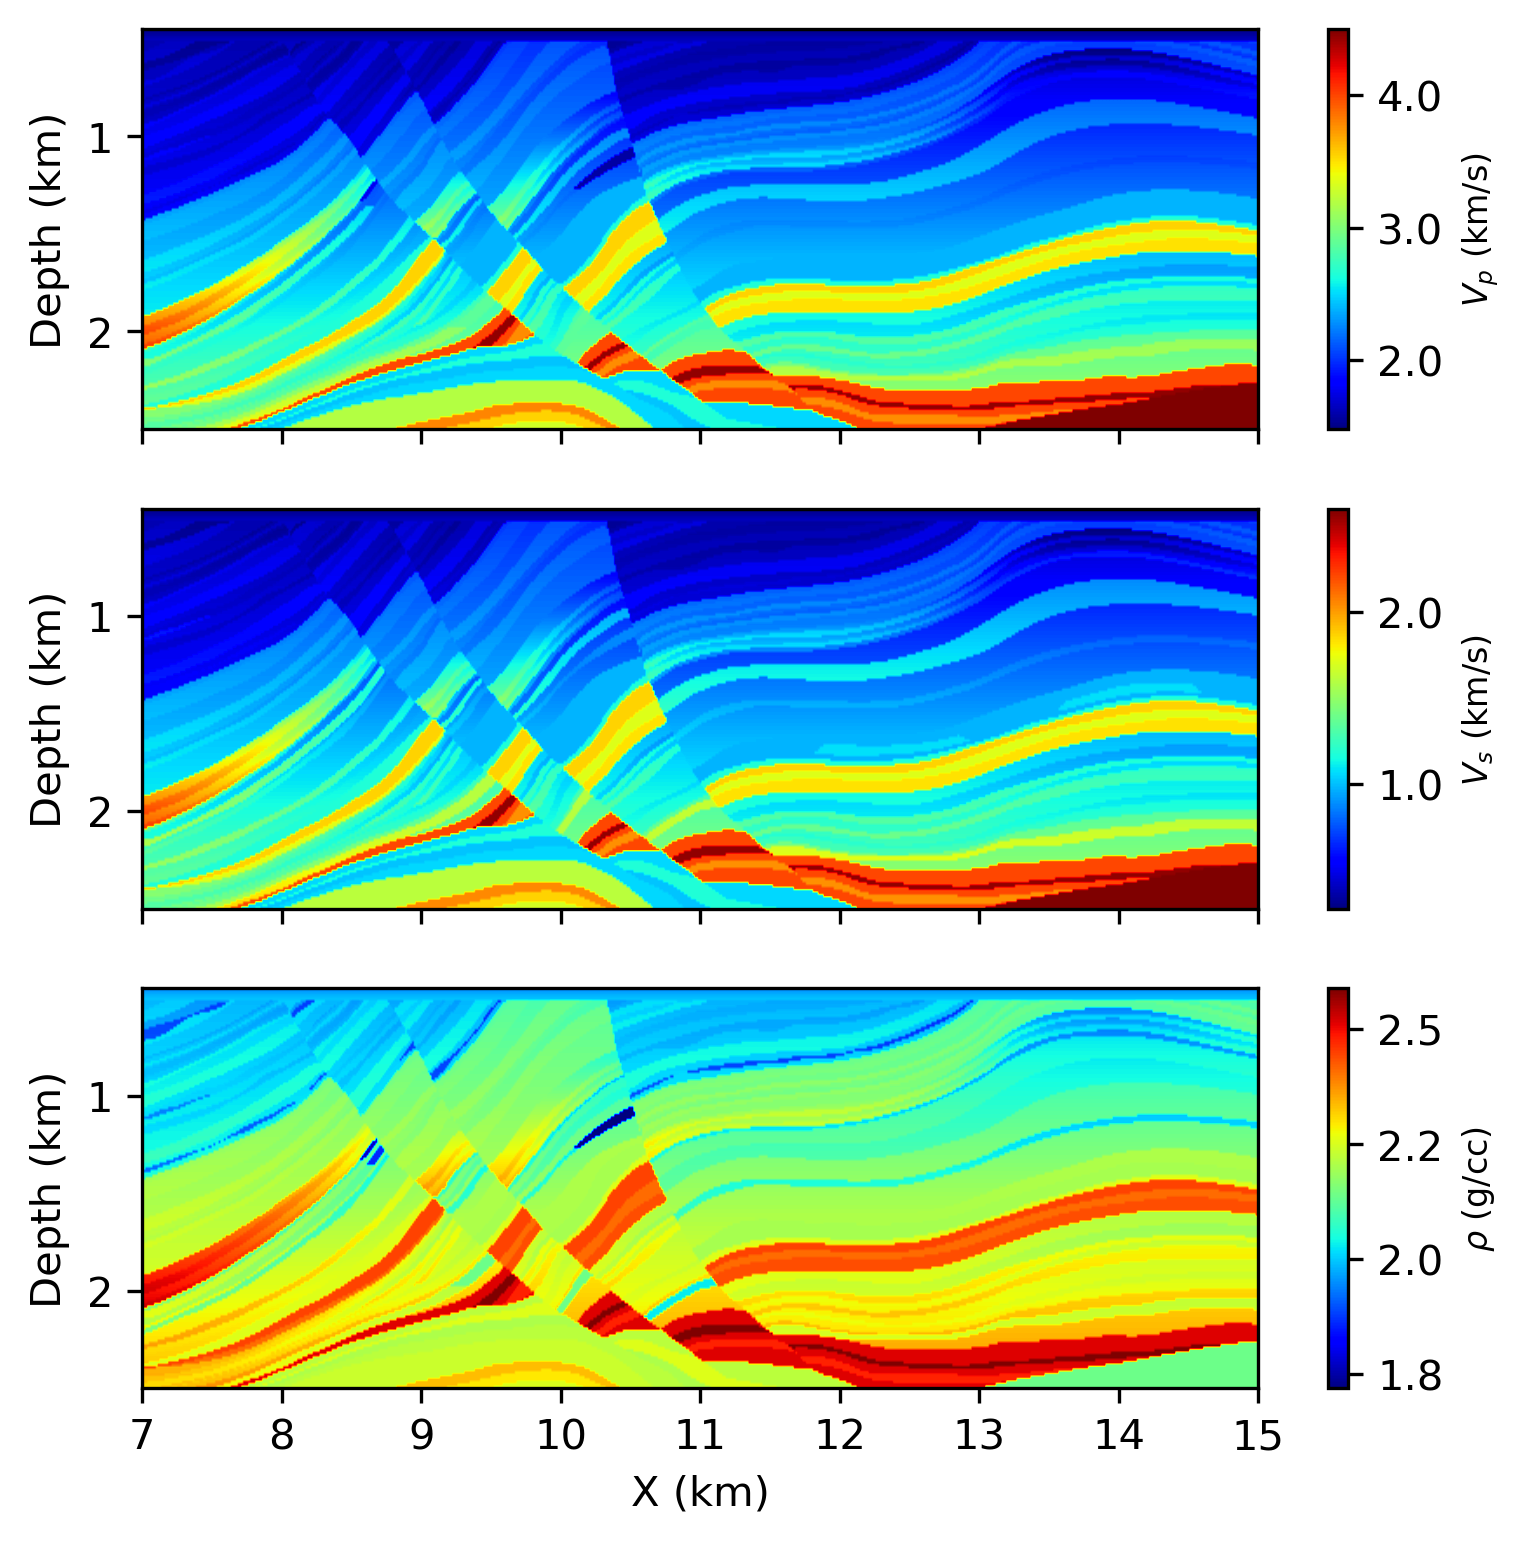

In [10]:
# plot the truncated Marmousi2 model as it will be used to generate pseud true data for FWI

fig, ax = plt.subplots(3,1,figsize=(6, 6),dpi=300)
im0=ax[0].imshow(np.transpose(vpcut),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],cmap='jet')
im1=ax[1].imshow(np.transpose(vscut),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],cmap='jet')
im2=ax[2].imshow(np.transpose(rhocut),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],cmap='jet')
ax[0].set(ylabel='Depth (km)')
ax[1].set(ylabel='Depth (km)')
ax[2].set(xlabel='X (km)',ylabel='Depth (km)')
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
cbar0=fig.colorbar(im0, ax=ax[0],format='%.'+str(1)+'f',aspect=20)
cbar1=fig.colorbar(im1, ax=ax[1],format='%.'+str(1)+'f',aspect=20)
cbar2=fig.colorbar(im2, ax=ax[2],format='%.'+str(1)+'f',aspect=20)
cbar0.set_label(label=r'$V_p$ (km/s)',size=8)
cbar1.set_label(label=r'$V_s$ (km/s)',size=8)
cbar2.set_label(label=r'$\rho$ (g/cc)',size=8)

In [11]:
# Smooth the model to be the starting model for FWI
# the actual starting model will be slightly smoother because of the B-spline parameterization in FWI
xsize=20
zsize=7
box=np.ones((xsize,zsize))/(xsize*zsize)
vpsmth=signal.convolve2d(vpcut, box, mode='same', boundary='symm')
vssmth=signal.convolve2d(vscut, box, mode='same', boundary='symm')
rhosmth=signal.convolve2d(rhocut, box, mode='same', boundary='symm')
vpsmth=signal.convolve2d(vpsmth, box, mode='same', boundary='symm')
vssmth=signal.convolve2d(vssmth, box, mode='same', boundary='symm')
rhosmth=signal.convolve2d(rhosmth, box, mode='same', boundary='symm')
vpsmth=signal.convolve2d(vpsmth, box, mode='same', boundary='symm')
vssmth=signal.convolve2d(vssmth, box, mode='same', boundary='symm')
rhosmth=signal.convolve2d(rhosmth, box, mode='same', boundary='symm')

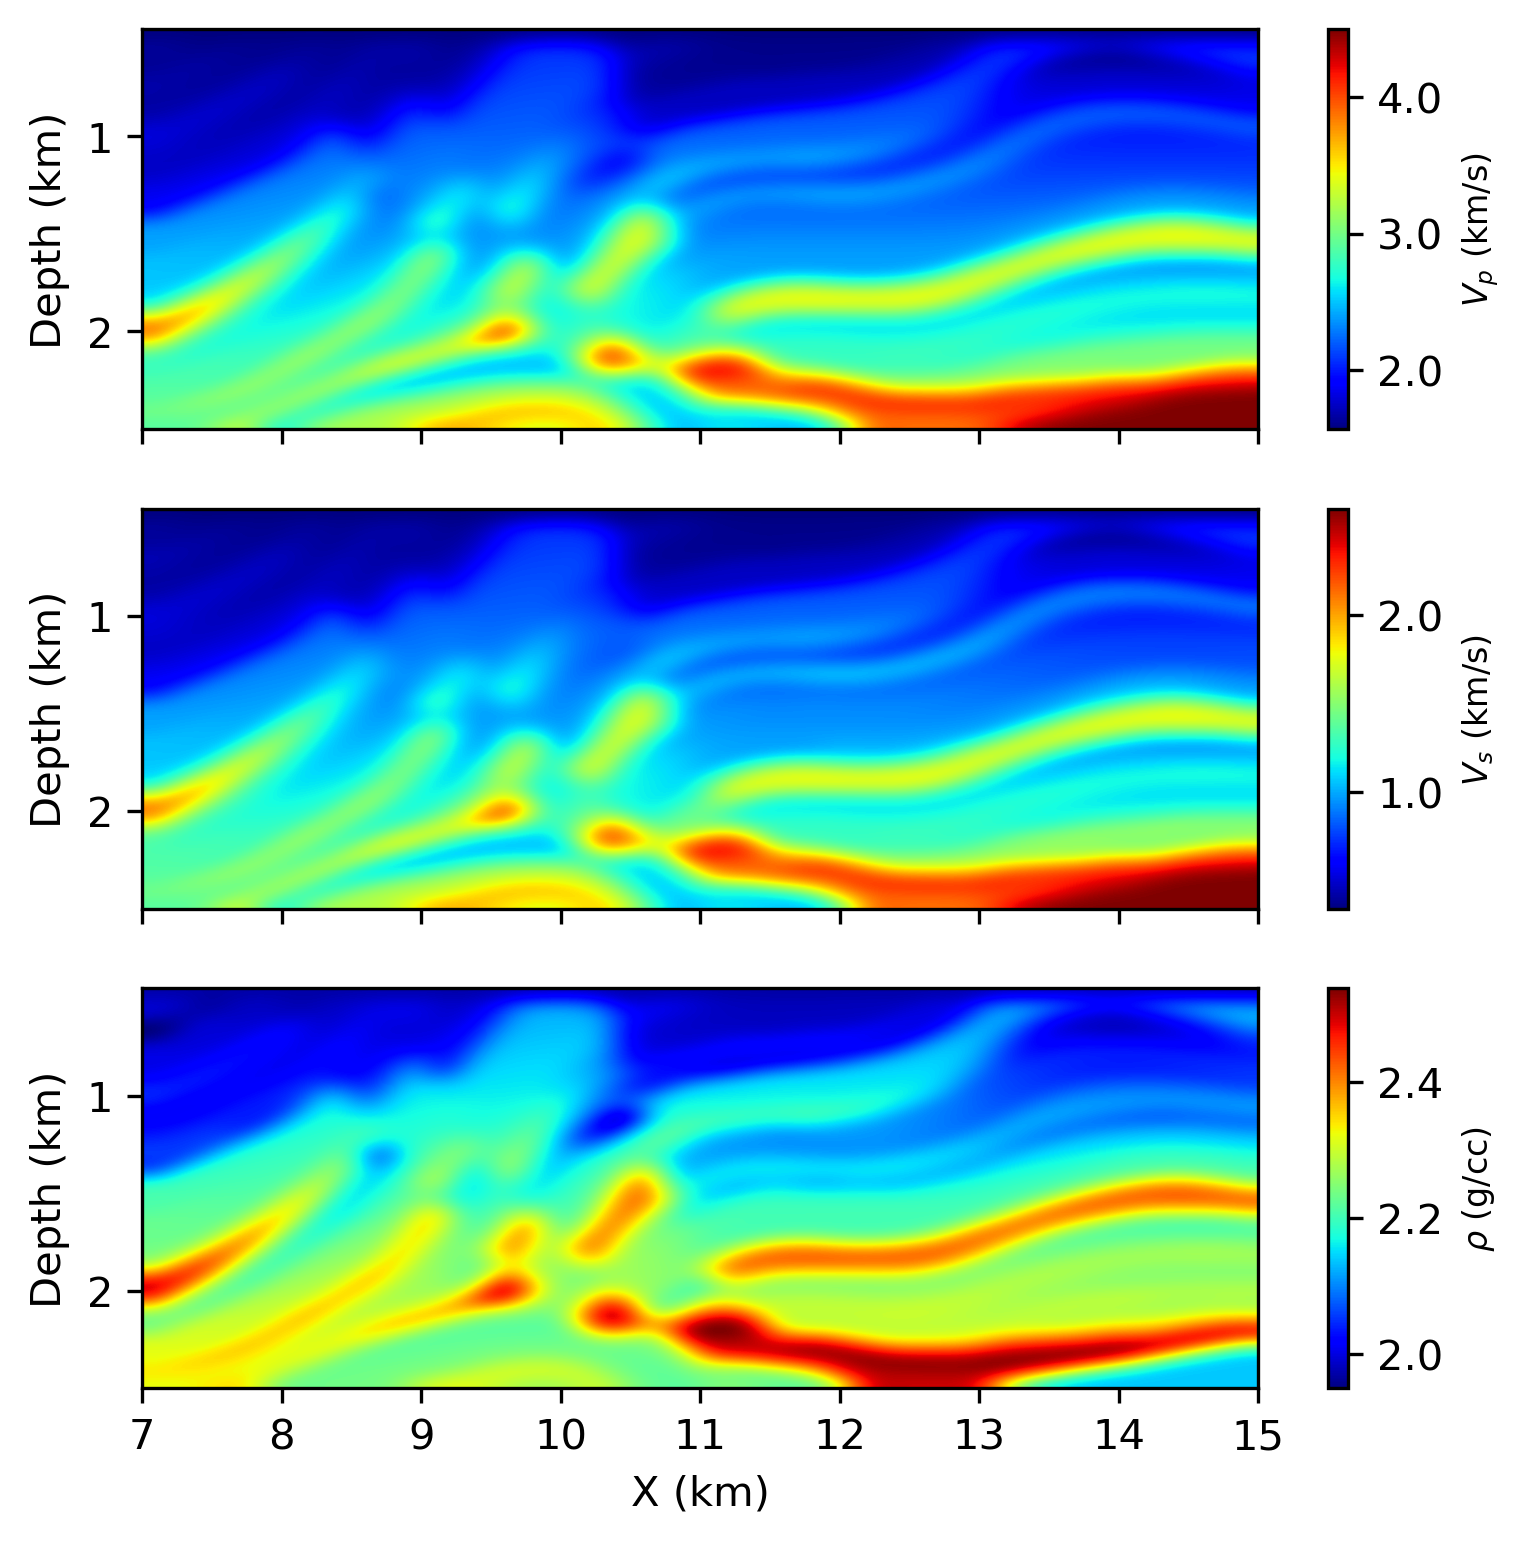

In [12]:
# plot the truncated Marmousi2 model after smoothing as it will be used in FWI (before B-spline projection)

fig, ax = plt.subplots(3,1,figsize=(6, 6),dpi=300)
im0=ax[0].imshow(np.transpose(vpsmth),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],cmap='jet')
im1=ax[1].imshow(np.transpose(vssmth),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],cmap='jet')
im2=ax[2].imshow(np.transpose(rhosmth),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],cmap='jet')
ax[0].set(ylabel='Depth (km)')
ax[1].set(ylabel='Depth (km)')
ax[2].set(xlabel='X (km)',ylabel='Depth (km)')
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
cbar0=fig.colorbar(im0, ax=ax[0],format='%.'+str(1)+'f',aspect=20)
cbar1=fig.colorbar(im1, ax=ax[1],format='%.'+str(1)+'f',aspect=20)
cbar2=fig.colorbar(im2, ax=ax[2],format='%.'+str(1)+'f',aspect=20)
cbar0.set_label(label=r'$V_p$ (km/s)',size=8)
cbar1.set_label(label=r'$V_s$ (km/s)',size=8)
cbar2.set_label(label=r'$\rho$ (g/cc)',size=8)

In [13]:
# create a gradient preconditioner
mask=np.ones((vpcut.shape))
mask[:,:6]=0
box2=np.ones((1,5))/5
mask=signal.convolve2d(mask, box, mode='same', boundary='symm')
mask=signal.convolve2d(mask, box, mode='same', boundary='symm')
mask=signal.convolve2d(mask, box, mode='same', boundary='symm')

# data weighting operator (basically 1 and 0 to mute out gephone components two FWI tests)
weights=np.ones((3,21,561,751))
weights[1:3,:,:,:]=0

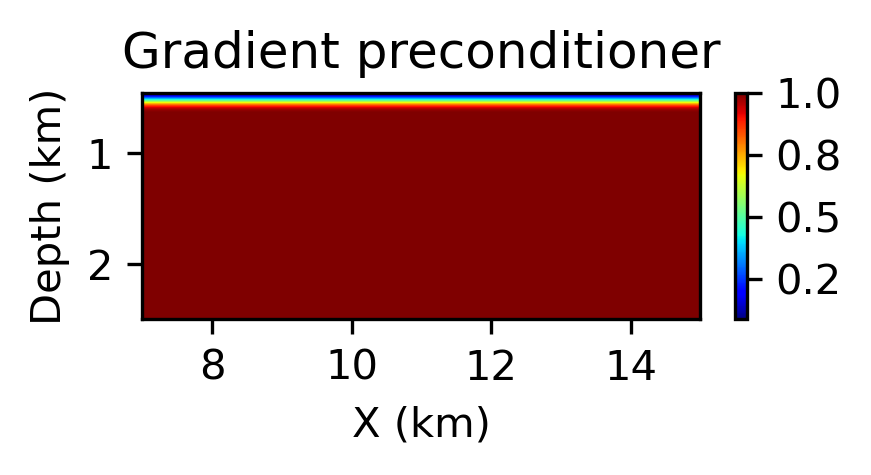

In [14]:
fig, ax = plt.subplots(1,1,figsize=(3, 1),dpi=300)
im0=ax.imshow(np.transpose(mask),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],cmap='jet')
ax.set(xlabel='X (km)',ylabel='Depth (km)')
ax.set_title("Gradient preconditioner")
cbar0=fig.colorbar(im0, ax=ax,format='%.'+str(1)+'f',aspect=20)

In [15]:
# save to numpy the true and smoothed models, the gradient preconditioner and the data weighting operator
emodel_true=np.array([vpcut,vscut,rhocut])
emodel_smth=np.array([vpsmth,vssmth,rhosmth])
emodel_mask=np.array([mask,mask,mask])

np.save('../dat/marmousi_true',emodel_true)
np.save('../dat/marmousi_smth',emodel_smth)
np.save('../dat/mask',emodel_mask)
np.save('../dat/weights',weights)

# convert to SEPlib for FWI and update the description file
!sep2numpy.py --input ../dat/marmousi_true.npy --mode 1 --datapath ${PWD}/../dat/ --output ../dat/marmousi_true.H
!sep2numpy.py --input ../dat/marmousi_smth.npy --mode 1 --datapath ${PWD}/../dat/ --output ../dat/marmousi_smth.H
!sep2numpy.py --input ../dat/mask.npy --mode 1 --datapath ${PWD}/../dat/ --output ../dat/mask.H
!sep2numpy.py --input ../dat/weights.npy --mode 1 --datapath ${PWD}/../dat/ --output ../dat/weights.H

!echo o1=0.45 o2=7 d1=0.0125 d2=0.0125 >> ../dat/marmousi_true.H
!echo o1=0.45 o2=7 d1=0.0125 d2=0.0125 >> ../dat/marmousi_smth.H
!echo o1=0.45 o2=7 d1=0.0125 d2=0.0125 >> ../dat/mask.H

In [16]:
# project the starting model onto the B-spline grid and back. This is the actual starting model for FWI
!BSPLINES.x < ../dat/marmousi_smth.H nx=321 nz=83 datapath=${PWD}/../dat/ > ../dat/marmousi_smth.H.bs

### Generate two pseudo true datasets, one is OBN like and one for floating hydrophones

Note: if MPI is enabled, it can be used to parallelize over shots (for modeling and inversion), e.g., by modifying the commands below to something like '!mpirun -np 8 ../fwi2d/local/...'. 

In [17]:
# dataset 1: 21 shots 30 m below the surface, 561 hydrophones and geophones at the sea floor
!WE_MODELING.x source=../dat/src2.H model=../dat/marmousi_true.H output=../dat/marmousi_data1.H datapath=${PWD}/../dat/ \
acoustic_elastic=1 acoustic_source=1 water_velocity=1.5 water_density=1 \
fmax=15 verbose=3 \
ns=21 sx0=7.5 sz0=0.03 sxinc=0.35 nr=561 rx0=7.5 rz0=0.45 rxinc=0.0125 seismotype=1 \
bc_top=1 free_surface_stiffness=1.2 bc_bottom=2 bc_left=2 bc_right=2 taper_top=0 taper_bottom=40 taper_left=40 taper_right=40 taper_strength=0.07

!echo n2=561 n3=21 n4=3 o4=0 d4=1 >> ../dat/marmousi_data1.H


 Subsurface model geometry
xmin=7.00000 km, xmax=15.00000 km, dx=0.01250 km, nx=641
zmin=0.45000 km, zmax=2.50000 km, dz=0.01250 km, nz=165
A fluid layer is implicitly added on top of the model, all the way up to z=0 km with nz=37 samples v=1.50 km/s and rho=1.00 g/cc

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared
Right boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared

 Sources' and receivers' geometry
Sources' and receivers' coordinates are read from parameters list
Receivers are dual point measurement of type hydraulic pressure and particle velocity
Number of sources = 21
All sources must fall within the fluid layer
Shot 0 located at x=7.50000 km, z=0.03000 km, has 561 receivers
Shot 1 located at x=7.85000 km, z=0.03000 k

Propagation progress = 90%
Propagation progress = 100%
Finish propagating shot 12 by process 0
Start propagating shot 13 by process 0
Propagation progress = 10%
Propagation progress = 20%
Propagation progress = 30%
Propagation progress = 40%
Propagation progress = 50%
Propagation progress = 60%
Propagation progress = 70%
Propagation progress = 80%
Propagation progress = 90%
Propagation progress = 100%
Finish propagating shot 13 by process 0
Start propagating shot 14 by process 0
Propagation progress = 10%
Propagation progress = 20%
Propagation progress = 30%
Propagation progress = 40%
Propagation progress = 50%
Propagation progress = 60%
Propagation progress = 70%
Propagation progress = 80%
Propagation progress = 90%
Propagation progress = 100%
Finish propagating shot 14 by process 0
Start propagating shot 15 by process 0
Propagation progress = 10%
Propagation progress = 20%
Propagation progress = 30%
Propagation progress = 40%
Propagation progress = 50%
Propagation progress = 60%
Prop

In [18]:
# dataset 2: 21 shots 30 m below the surface, 561 hydrophones 30 m below the surface and geophones on the sea floor
# the geophones will be discarded in the inversion
!WE_MODELING.x source=../dat/src2.H model=../dat/marmousi_true.H output=../dat/marmousi_data2.H datapath=${PWD}/../dat/ \
acoustic_elastic=1 acoustic_source=1 water_velocity=1.5 water_density=1 \
fmax=15 verbose=3 \
ns=21 sx0=7.5 sz0=0.03 sxinc=0.35 nr=561 rx0=7.5 rz0=0.03 rxinc=0.0125 seismotype=1 \
bc_top=1 free_surface_stiffness=1.2 bc_bottom=2 bc_left=2 bc_right=2 taper_top=0 taper_bottom=40 taper_left=40 taper_right=40 taper_strength=0.07

!echo n2=561 n3=21 n4=3 o4=0 d4=1 ../dat/marmousi_data2.H


 Subsurface model geometry
xmin=7.00000 km, xmax=15.00000 km, dx=0.01250 km, nx=641
zmin=0.45000 km, zmax=2.50000 km, dz=0.01250 km, nz=165
A fluid layer is implicitly added on top of the model, all the way up to z=0 km with nz=37 samples v=1.50 km/s and rho=1.00 g/cc

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared
Right boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared

 Sources' and receivers' geometry
Sources' and receivers' coordinates are read from parameters list
Receivers are dual point measurement of type hydraulic pressure and particle velocity
Number of sources = 21
All sources must fall within the fluid layer
Shot 0 located at x=7.50000 km, z=0.03000 km, has 561 receivers
Shot 1 located at x=7.85000 km, z=0.03000 k

Propagation progress = 90%
Propagation progress = 100%
Finish propagating shot 12 by process 0
Start propagating shot 13 by process 0
Propagation progress = 10%
Propagation progress = 20%
Propagation progress = 30%
Propagation progress = 40%
Propagation progress = 50%
Propagation progress = 60%
Propagation progress = 70%
Propagation progress = 80%
Propagation progress = 90%
Propagation progress = 100%
Finish propagating shot 13 by process 0
Start propagating shot 14 by process 0
Propagation progress = 10%
Propagation progress = 20%
Propagation progress = 30%
Propagation progress = 40%
Propagation progress = 50%
Propagation progress = 60%
Propagation progress = 70%
Propagation progress = 80%
Propagation progress = 90%
Propagation progress = 100%
Finish propagating shot 14 by process 0
Start propagating shot 15 by process 0
Propagation progress = 10%
Propagation progress = 20%
Propagation progress = 30%
Propagation progress = 40%
Propagation progress = 50%
Propagation progress = 60%
Prop

### Run 3 FWI tests using SBP-SAT. Each run will take ~6.5 hours on a single 24 cores machine (the cost will be cut almost proportionally to the number of tasks if MPI is utilized)

In [ ]:
# run FWI using hydrophones and geophones at the sea floor
!FWI2D.x source=../dat/src2.H model=../dat/marmousi_smth.H data=../dat/marmousi_data1.H mask=../dat/mask.H output=../dat/fwi1a.H obj_func=../dat/fwi1a.H.func datapath=${PWD}/../dat/ \
acoustic_elastic=1 acoustic_source=1 water_velocity=1.5 water_density=1 \
fmax=15 verbose=1 \
ns=21 sx0=7.5 sz0=0.03 sxinc=0.35 nr=561 rx0=7.5 rz0=0.45 rxinc=0.0125 seismotype=1 \
bc_top=1 free_surface_stiffness=1.2 bc_bottom=2 bc_left=2 bc_right=2 taper_top=0 taper_bottom=40 taper_left=40 taper_right=40 taper_strength=0.07 \
bsplines=1 bs_nx=321 bs_nz=83 integrate=1 \
nlsolver=lbfgs niter=30 max_trial=7 lsearch=regular_wolfe sub=10 isave=10 ioutput=../dat/fwi1a.H. \
vpmin=1 vpmax=5 vsmin=0.1 vsmax=3 rhomin=1 rhomax=3 soft_clip=1 \
nthreads=$OMP_NUM_THREADS 2> ../dat/fwi1a.H.log


 Subsurface model geometry
xmin=7.00000 km, xmax=15.00000 km, dx=0.01250 km, nx=641
zmin=0.45000 km, zmax=2.50000 km, dz=0.01250 km, nz=165
A fluid layer is implicitly added on top of the model, all the way up to z=0 km with nz=37 samples v=1.50 km/s and rho=1.00 g/cc

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared
Right boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared

 Sources' and receivers' geometry
Sources' and receivers' coordinates are read from parameters list
Receivers are dual point measurement of type hydraulic pressure and particle velocity
Number of sources = 21
All sources must fall within the fluid layer
Shot 0 located at x=7.50000 km, z=0.03000 km, has 561 receivers
Shot 1 located at x=7.85000 km, z=0.03000 k


Fri Apr  1 11:59:37 2022

Trial = 1
Step length = 7.321789
Function value = 0.081450
Last gradient norm = 0.005675

Fri Apr  1 12:05:02 2022

Trial = 2
Step length = 2.455972
Function value = 0.074149
Gradient norm = 0.009176
Found a satisfactory step length
#########################################################################
Iteration = 10; functional = 0.074149; normalized functional = 0.615682
#########################################################################

Fri Apr  1 12:10:29 2022

Trial = 1
Step length = 1.157488
Function value = 0.071248
Gradient norm = 0.008286
Found a satisfactory step length
#########################################################################
Iteration = 11; functional = 0.071248; normalized functional = 0.591591
#########################################################################

Fri Apr  1 12:15:52 2022

Trial = 1
Step length = 0.497356
Function value = 0.068255
Gradient norm = 0.007131
Found a satisfactory step length
############

In [ ]:
# run FWI using hydrophones only at the sea floor
!FWI2D.x source=../dat/src2.H model=../dat/marmousi_smth.H data=../dat/marmousi_data1.H mask=../dat/mask.H weights=../dat/weights.H output=../dat/fwi2a.H obj_func=../dat/fwi2a.H.func datapath=${PWD}/../dat/ \
acoustic_elastic=1 acoustic_source=1 water_velocity=1.5 water_density=1 \
fmax=15 verbose=1 \
ns=21 sx0=7.5 sz0=0.03 sxinc=0.35 nr=561 rx0=7.5 rz0=0.45 rxinc=0.0125 seismotype=1 \
bc_top=1 free_surface_stiffness=1.2 bc_bottom=2 bc_left=2 bc_right=2 taper_top=0 taper_bottom=40 taper_left=40 taper_right=40 taper_strength=0.07 \
bsplines=1 bs_nx=321 bs_nz=83 integrate=1 \
nlsolver=lbfgs niter=30 max_trial=7 lsearch=regular_wolfe sub=10 isave=10 ioutput=../dat/fwi2a.H. \
vpmin=1 vpmax=5 vsmin=0.1 vsmax=3 rhomin=1 rhomax=3 soft_clip=1 \
nthreads=$OMP_NUM_THREADS 2> ../dat/fwi2a.H.log

In [ ]:
# run FWI using hydrophones only 30 m below the surface
!FWI2D.x source=../dat/src2.H model=../dat/marmousi_smth.H data=../dat/marmousi_data2.H mask=../dat/mask.H weights=../dat/weights.H output=../dat/fwi3a.H obj_func=../dat/fwi3a.H.func datapath=${PWD}/../dat/ \
acoustic_elastic=1 acoustic_source=1 water_velocity=1.5 water_density=1 \
fmax=15 verbose=1 \
ns=21 sx0=7.5 sz0=0.03 sxinc=0.35 nr=561 rx0=7.5 rz0=0.03 rxinc=0.0125 seismotype=1 \
bc_top=1 free_surface_stiffness=1.2 bc_bottom=2 bc_left=2 bc_right=2 taper_top=0 taper_bottom=40 taper_left=40 taper_right=40 taper_strength=0.07 \
bsplines=1 bs_nx=321 bs_nz=83 integrate=1 \
nlsolver=lbfgs niter=30 max_trial=7 lsearch=regular_wolfe sub=10 isave=10 ioutput=../dat/fwi3a.H. \
vpmin=1 vpmax=5 vsmin=0.1 vsmax=3 rhomin=1 rhomax=3 soft_clip=1 \
nthreads=$OMP_NUM_THREADS 2> ../dat/fwi3a.H.log


 Subsurface model geometry
xmin=7.00000 km, xmax=15.00000 km, dx=0.01250 km, nx=641
zmin=0.45000 km, zmax=2.50000 km, dz=0.01250 km, nz=165
A fluid layer is implicitly added on top of the model, all the way up to z=0 km with nz=37 samples v=1.50 km/s and rho=1.00 g/cc

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared
Right boundary condition = locally absorbing	 taper size = 40	 taper type = cosine squared

 Sources' and receivers' geometry
Sources' and receivers' coordinates are read from parameters list
Receivers are dual point measurement of type hydraulic pressure and particle velocity
Number of sources = 21
All sources must fall within the fluid layer
Shot 0 located at x=7.50000 km, z=0.03000 km, has 561 receivers
Shot 1 located at x=7.85000 km, z=0.03000 k

### Convert all outputs to numpy

In [30]:
!sep2numpy.py --input ../dat/marmousi_data1.H --output ../dat/marmousi_data1 --mode 0
!sep2numpy.py --input ../dat/marmousi_smth.H.bs --output ../dat/marmousi_smth_bs --mode 0
!sep2numpy.py --input ../dat/fwi1a.H --output ../dat/fwi1a --mode 0
!sep2numpy.py --input ../dat/fwi2a.H --output ../dat/fwi2a --mode 0
!sep2numpy.py --input ../dat/fwi3a.H --output ../dat/fwi3a --mode 0
!sep2numpy.py --input ../dat/fwi1a.H.func --output ../dat/fwi1a_func --mode 0
!sep2numpy.py --input ../dat/fwi2a.H.func --output ../dat/fwi2a_func --mode 0
!sep2numpy.py --input ../dat/fwi3a.H.func --output ../dat/fwi3a_func --mode 0

### Data example figures

In [31]:
# load pseudo-true data
data=np.load('../dat/marmousi_data1.npy')

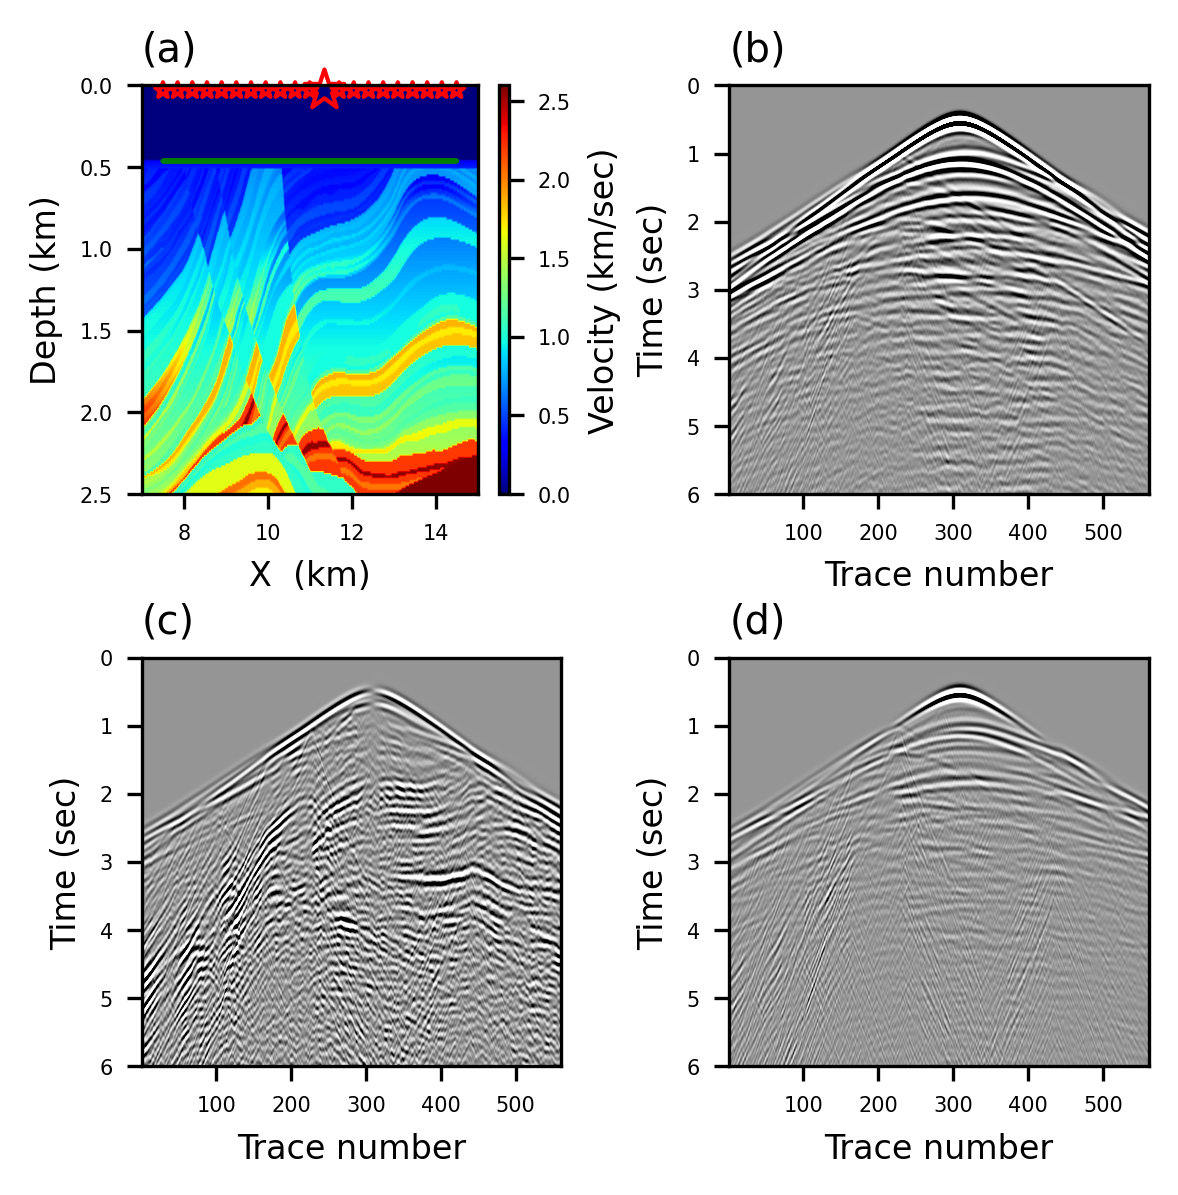

In [32]:
vscut2=vs[:,np.arange(0,2002,10)]
vscut2=0.001*vscut2[np.arange(5600,12001,10),:]
sp=11

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(2,2,figsize=(4.33, 4.33),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
im0=ax[0,0].imshow(np.transpose(vscut2),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0],cmap='jet')
im1=ax[0,1].imshow(np.transpose(data[0,sp,:,:]),interpolation='sinc',aspect="auto",extent=[1,561,6,0],vmin=-0.25,vmax=0.25,cmap='Greys')
im2=ax[1,0].imshow(np.transpose(data[1,sp,:,:]),interpolation='sinc',aspect="auto",extent=[1,561,6,0],vmin=-0.25,vmax=0.25,cmap='Greys')
im3=ax[1,1].imshow(np.transpose(data[2,sp,:,:]),interpolation='sinc',aspect="auto",extent=[1,561,6,0],vmin=-0.25,vmax=0.25,cmap='Greys')

ax[0,0].set(xlabel="X  (km)",ylabel='Depth (km)')
ax[0,1].set(xlabel='Trace number',ylabel='Time (sec)')
ax[1,0].set(xlabel='Trace number',ylabel='Time (sec)')
ax[1,1].set(xlabel='Trace number',ylabel='Time (sec)')
#ax[0,1].set_xticklabels([])
#ax[1,1].set_yticklabels([])

ax[0,0].tick_params(axis='both', which='major', labelsize=5)
ax[0,1].tick_params(axis='both', which='major', labelsize=5)
ax[1,0].tick_params(axis='both', which='major', labelsize=5)
ax[1,1].tick_params(axis='both', which='major', labelsize=5)

#ax[0,0].set_title(r'(a) Marmousi2 $V_S$',loc='center')
#ax[0,1].set_title(r'(b) Pressure component',loc='center')
#ax[1,0].set_title(r'(c) $v_x$ component',loc='center')
#ax[1,1].set_title(r'(d) $v_z$ component',loc='center')
ax[0,0].set_title(r'(a)',loc='left')
ax[0,1].set_title(r'(b)',loc='left')
ax[1,0].set_title(r'(c)',loc='left')
ax[1,1].set_title(r'(d)',loc='left')

cbar=fig.colorbar(im0, ax=ax[0,0],format='%.'+str(1)+'f',aspect=40)
cbar.ax.tick_params(labelsize=5)
cbar.set_label(label=r'Velocity (km/sec)',size=8)

for i in range(21):
    if i==sp:
        ax[0,0].scatter([7.5+i*0.35], [0.03],marker='*',edgecolors='r',facecolors='none',s=100,clip_on=False)
    else:
        ax[0,0].scatter([7.5+i*0.35], [0.03],marker='*',edgecolors='r',facecolors='none',s=15,clip_on=False)

for i in range(561):
    ax[0,0].scatter([7.5+i*0.0125],[0.4625],marker='.',edgecolors='g',facecolors='none',s=.2)
        
#plt.delaxes(ax[1,0])
#plt.tight_layout()

#plt.show()
#plt.savefig('../fig/gather.png',bbox_inches='tight',format='png')

In [33]:
# load starting and inverted models
mod0=np.load('../dat/marmousi_smth_bs.npy')
fwi1=np.load('../dat/fwi1a.npy')
fwi2=np.load('../dat/fwi2a.npy')
fwi3=np.load('../dat/fwi3a.npy')

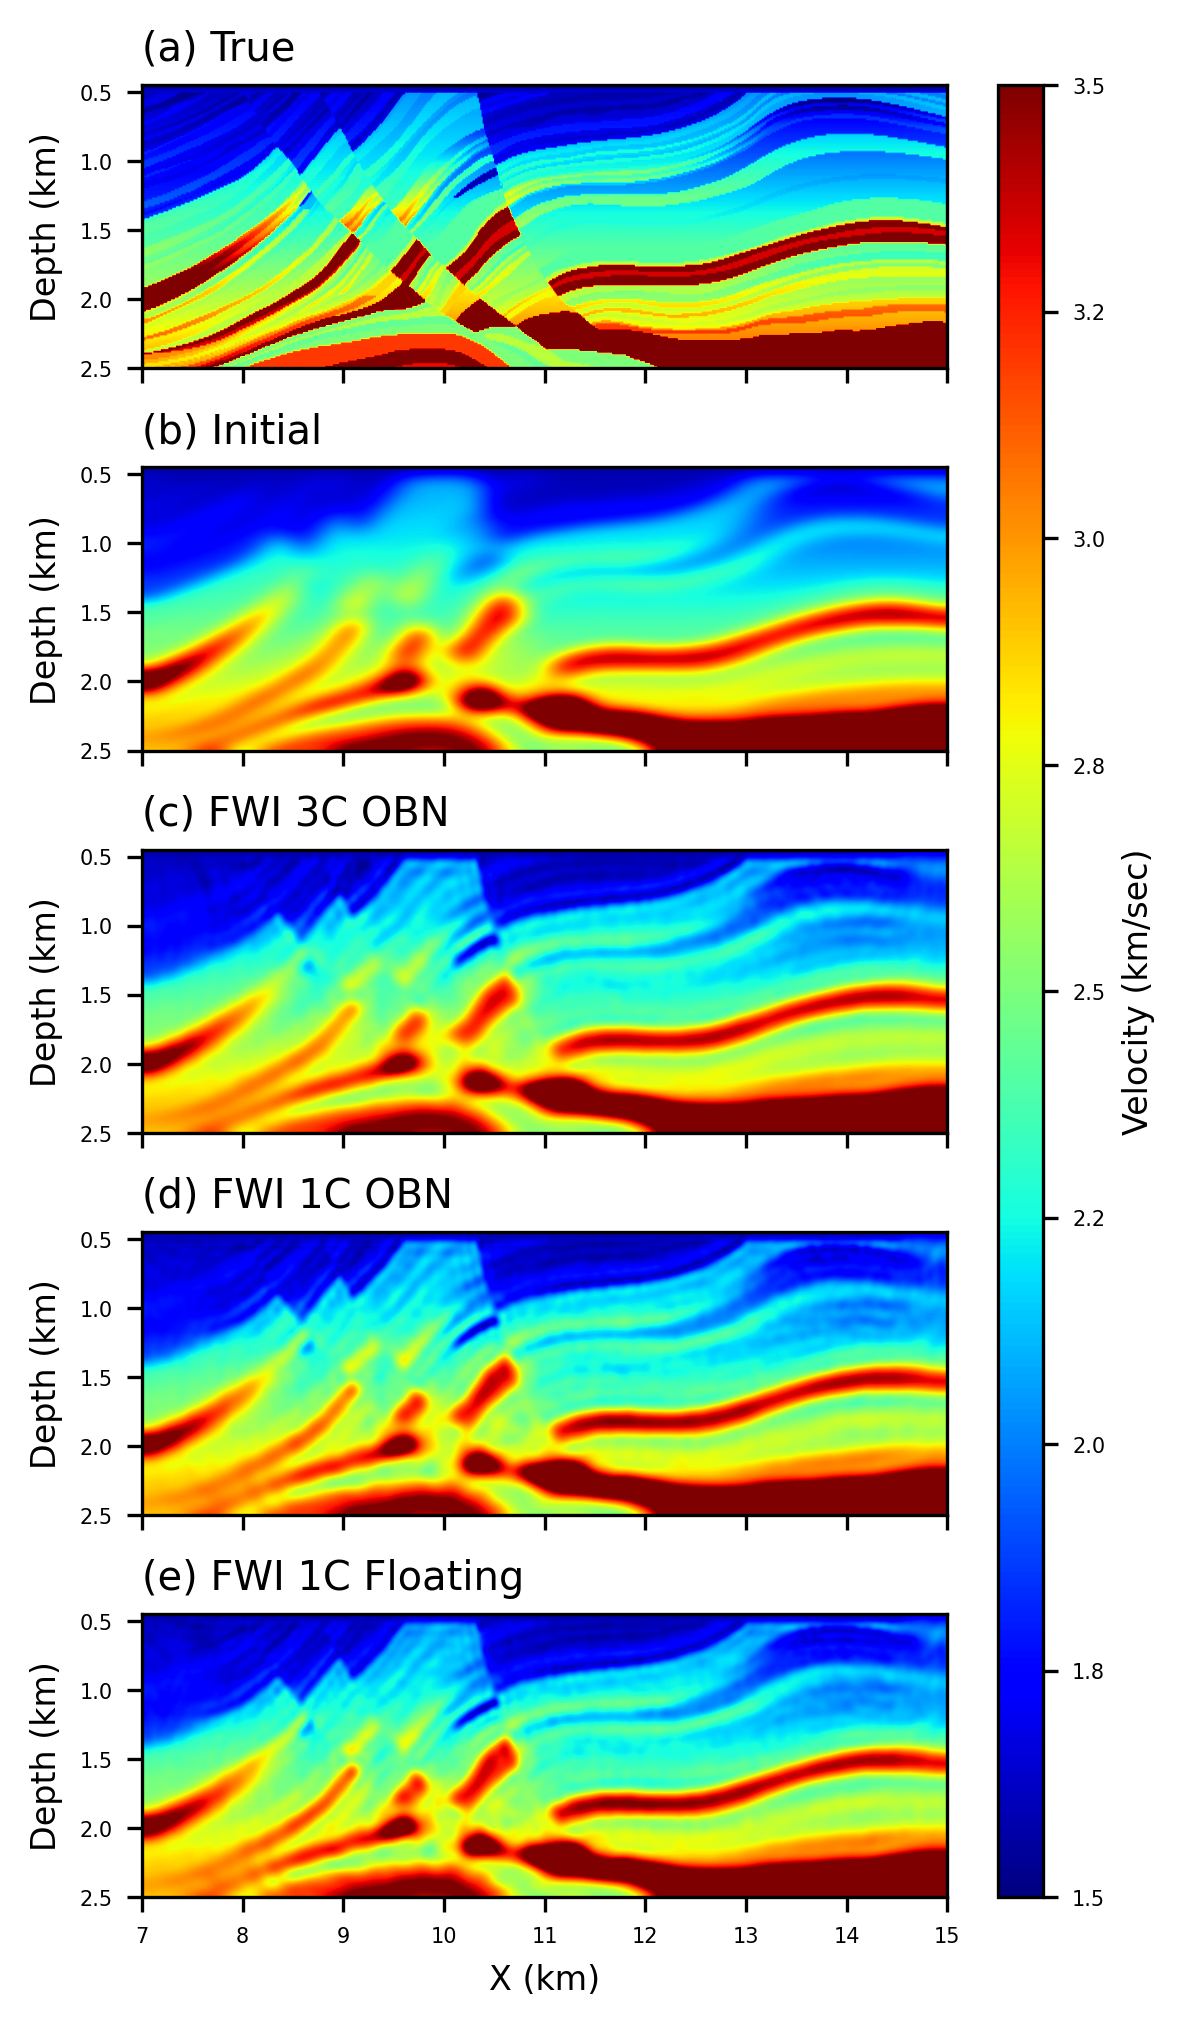

In [34]:
vmin=1.5
vmax=3.5

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(5,1,figsize=(4.33, 8),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.35)
im0=ax[0].imshow(np.transpose(vpcut),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],  vmin=vmin, vmax=vmax, cmap='jet')
im1=ax[1].imshow(np.transpose(mod0[0]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')
im2=ax[2].imshow(np.transpose(fwi1[0]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')
im3=ax[3].imshow(np.transpose(fwi2[0]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')
im4=ax[4].imshow(np.transpose(fwi3[0]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')

titles=np.array(['(a) True','(b) Initial','(c) FWI 3C OBN','(d) FWI 1C OBN','(e) FWI 1C Floating'])

for i in range(4):
    ax[i].set_xticklabels([])

for i in range(5):
    ax[i].set(ylabel='Depth (km)')
    ax[i].set_title(titles[i],loc='left')
    ax[i].tick_params(axis='both', which='major', labelsize=5)

ax[4].set(xlabel='X (km)')


cbar=fig.colorbar(im0, ax=ax.ravel().tolist(),format='%.'+str(1)+'f',aspect=40)
cbar.ax.tick_params(labelsize=5)
cbar.set_label(label=r'Velocity (km/sec)',size=8)

#plt.show()
#plt.savefig('../fig/vp.png',bbox_inches='tight',format='png')

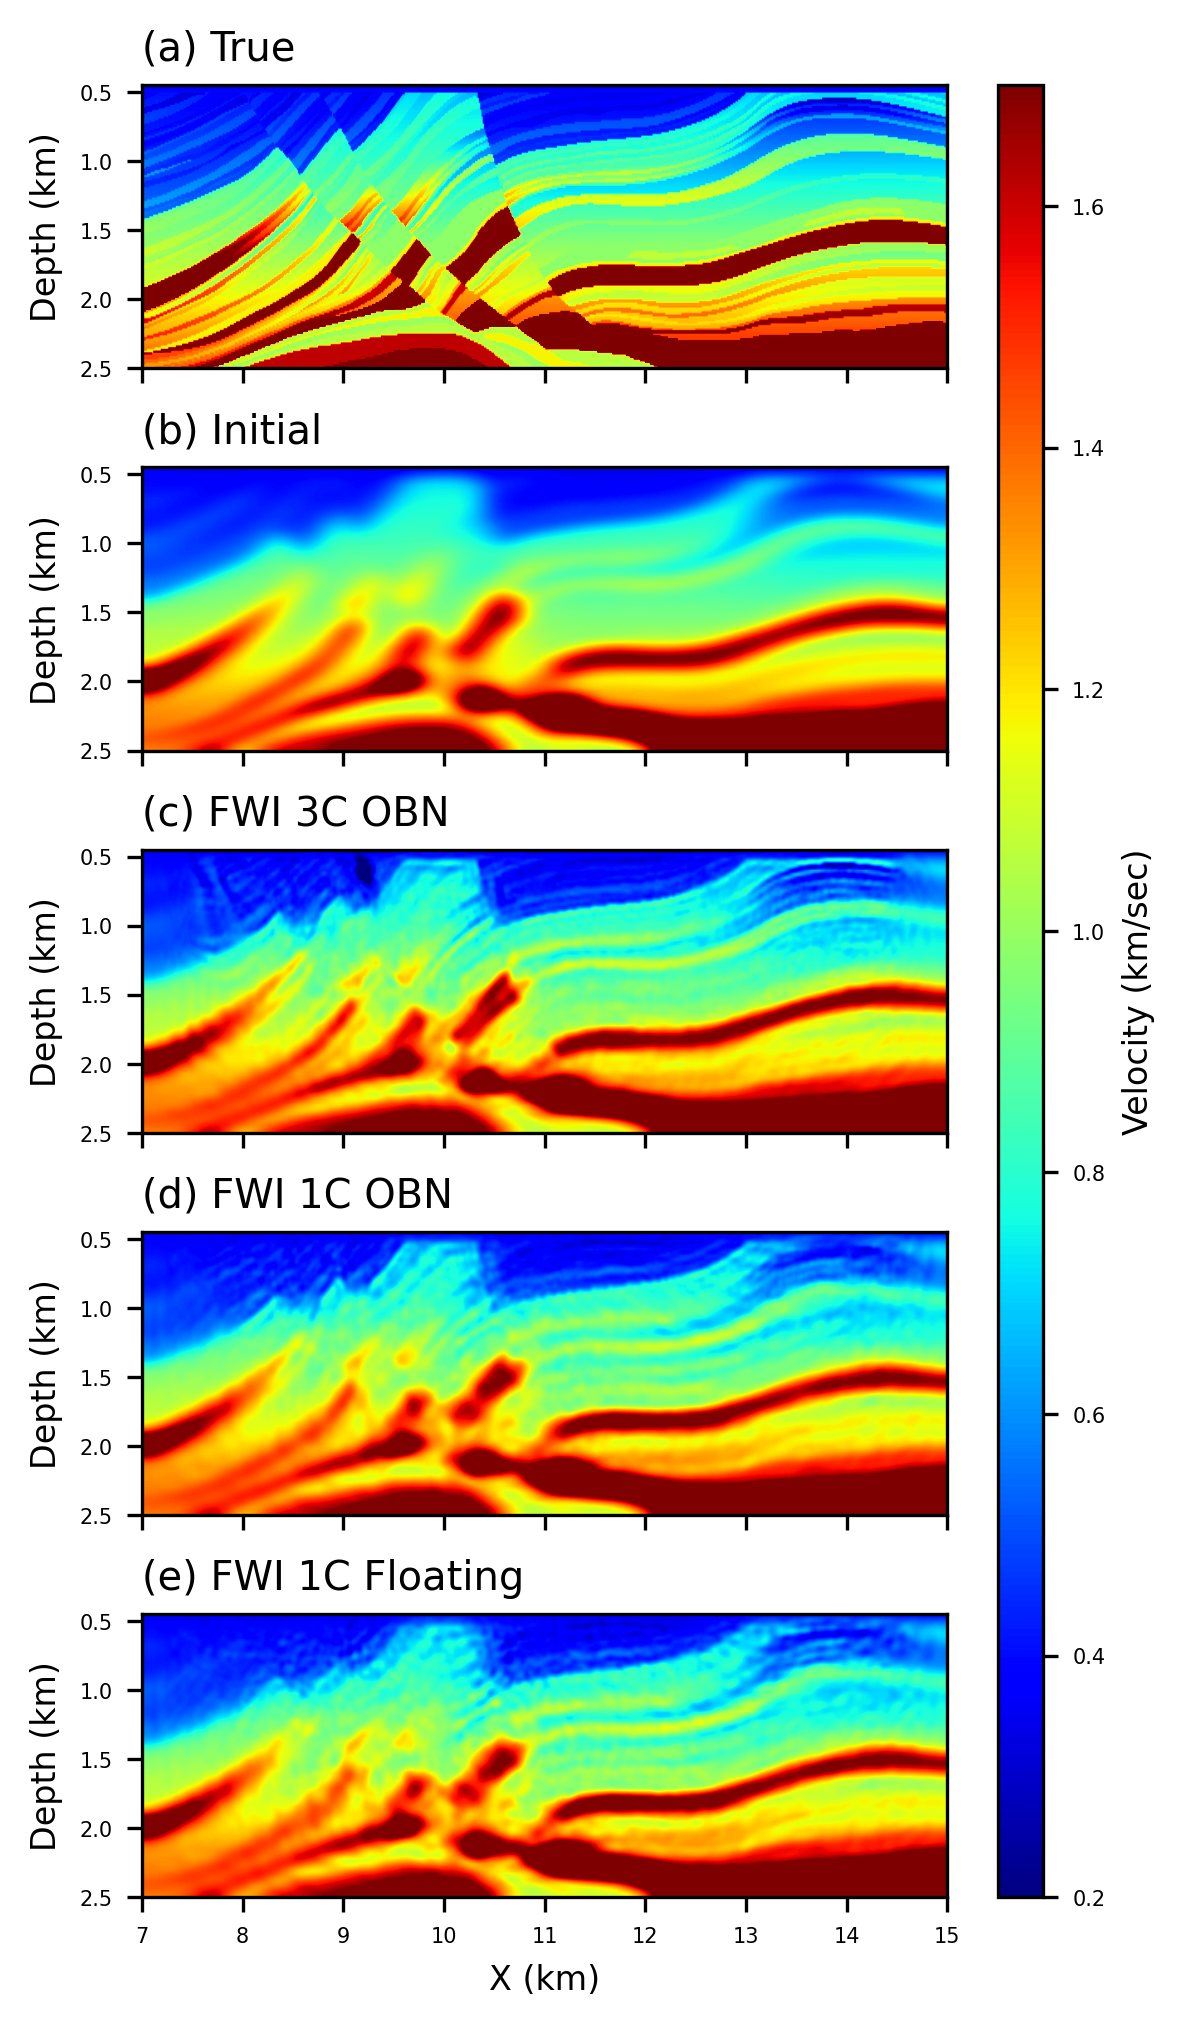

In [35]:
vmin=0.2
vmax=1.7

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(5,1,figsize=(4.33, 8),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.35)
im0=ax[0].imshow(np.transpose(vscut),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],  vmin=vmin, vmax=vmax, cmap='jet')
im1=ax[1].imshow(np.transpose(mod0[1]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')
im2=ax[2].imshow(np.transpose(fwi1[1]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')
im3=ax[3].imshow(np.transpose(fwi2[1]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')
im4=ax[4].imshow(np.transpose(fwi3[1]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')

titles=np.array(['(a) True','(b) Initial','(c) FWI 3C OBN','(d) FWI 1C OBN','(e) FWI 1C Floating'])

for i in range(4):
    ax[i].set_xticklabels([])

for i in range(5):
    ax[i].set(ylabel='Depth (km)')
    ax[i].set_title(titles[i],loc='left')
    ax[i].tick_params(axis='both', which='major', labelsize=5)

ax[4].set(xlabel='X (km)')


cbar=fig.colorbar(im0, ax=ax.ravel().tolist(),format='%.'+str(1)+'f',aspect=40)
cbar.ax.tick_params(labelsize=5)
cbar.set_label(label=r'Velocity (km/sec)',size=8)

#plt.show()
#plt.savefig('../fig/vs.png',bbox_inches='tight',format='png')

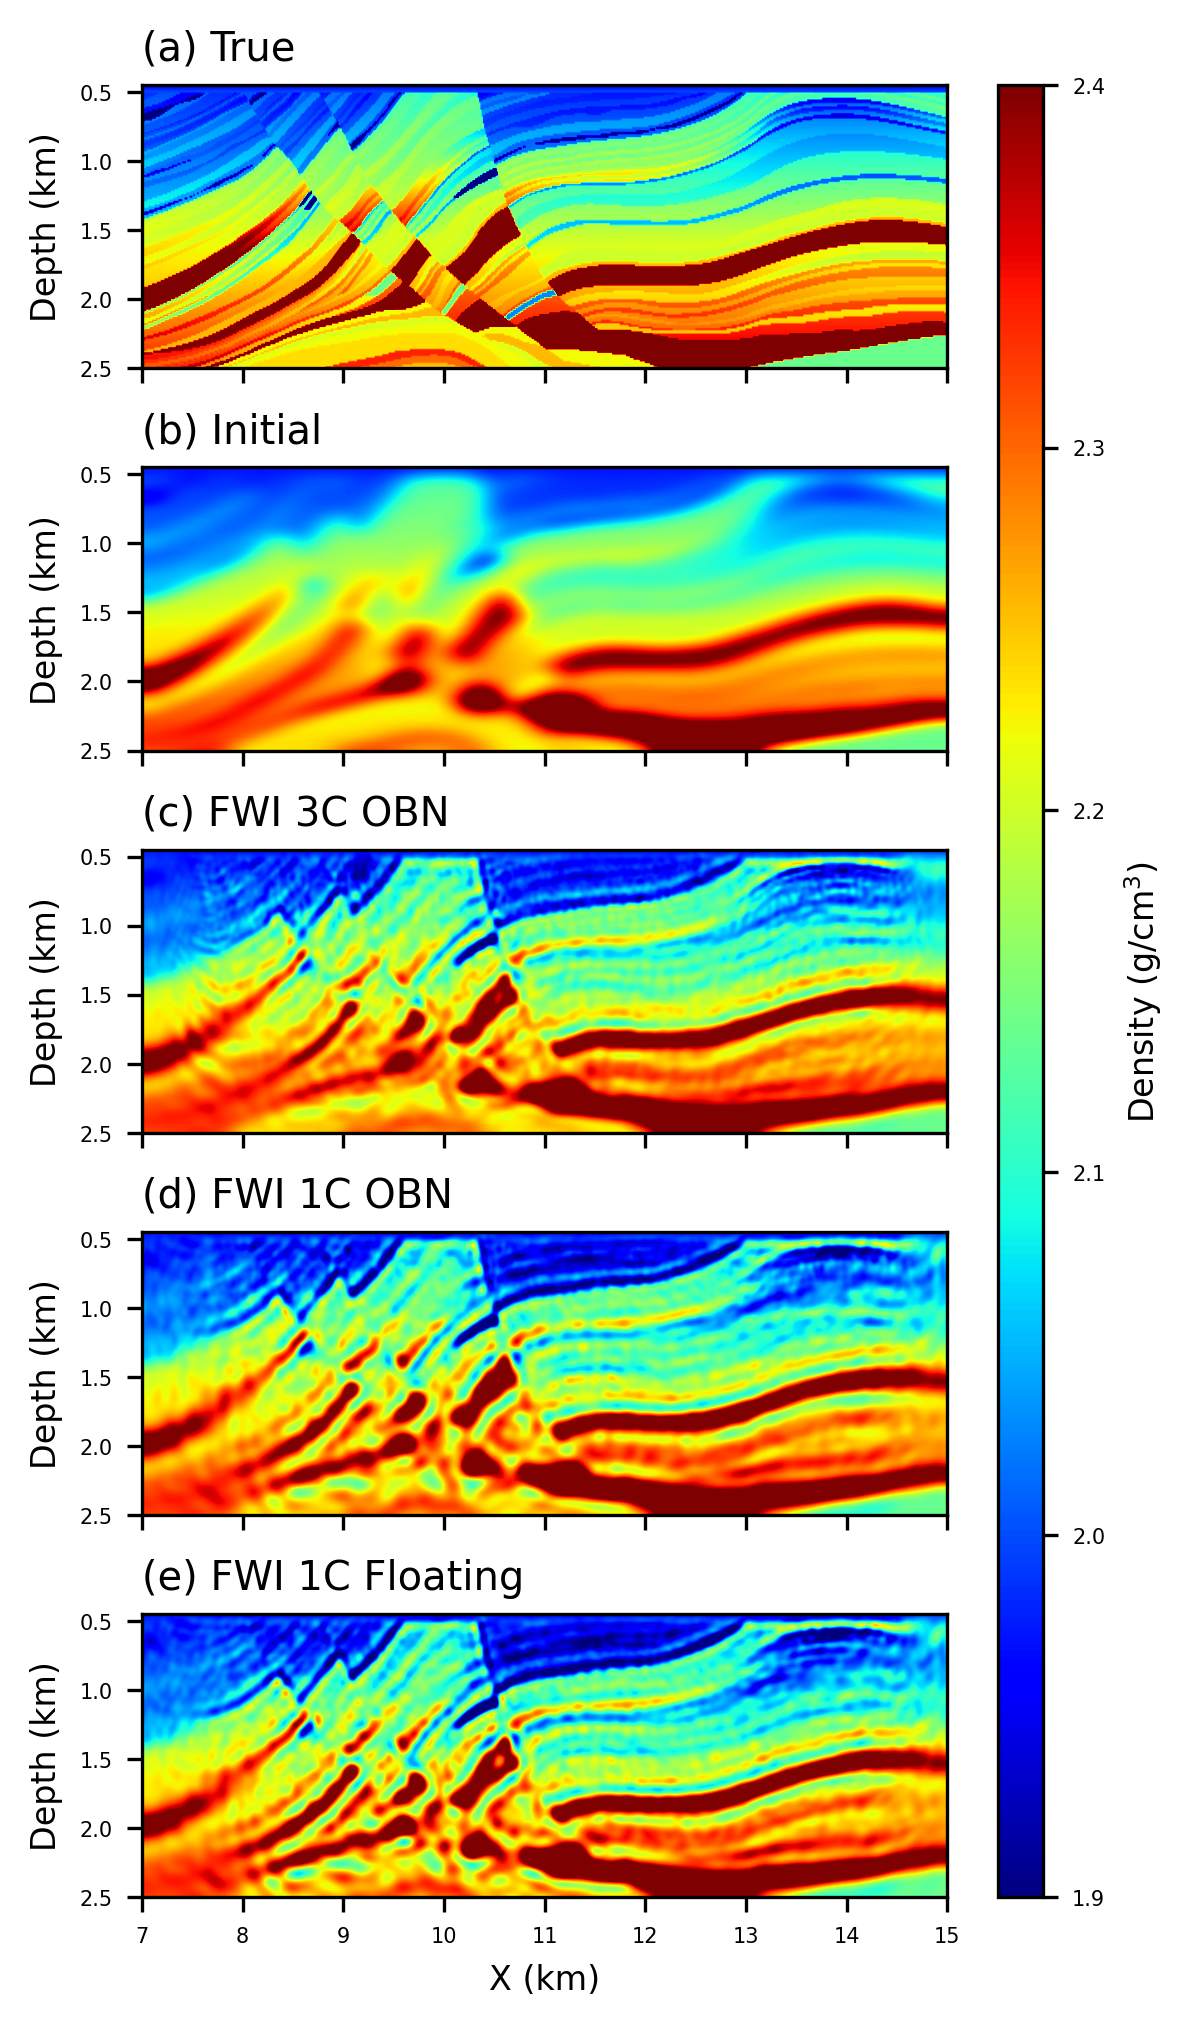

In [36]:
vmin=1.9
vmax=2.4

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(5,1,figsize=(4.33, 8),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.35)
im0=ax[0].imshow(np.transpose(rhocut),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],  vmin=vmin, vmax=vmax, cmap='jet')
im1=ax[1].imshow(np.transpose(mod0[2]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')
im2=ax[2].imshow(np.transpose(fwi1[2]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')
im3=ax[3].imshow(np.transpose(fwi2[2]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')
im4=ax[4].imshow(np.transpose(fwi3[2]),interpolation='bilinear',aspect="auto",extent=[7,15,2.5,0.45],vmin=vmin, vmax=vmax, cmap='jet')

titles=np.array(['(a) True','(b) Initial','(c) FWI 3C OBN','(d) FWI 1C OBN','(e) FWI 1C Floating'])

for i in range(4):
    ax[i].set_xticklabels([])

for i in range(5):
    ax[i].set(ylabel='Depth (km)')
    ax[i].set_title(titles[i],loc='left')
    ax[i].tick_params(axis='both', which='major', labelsize=5)

ax[4].set(xlabel='X (km)')


cbar=fig.colorbar(im0, ax=ax.ravel().tolist(),format='%.'+str(1)+'f',aspect=40)
cbar.ax.tick_params(labelsize=5)
cbar.set_label(label=r'Density (g/cm$^3$)',size=8)

#plt.show()
#plt.savefig('../fig/rho.png',bbox_inches='tight',format='png')

### Normalized objective functions

In [37]:
# load functionals
func1=np.load('../dat/fwi1a_func.npy')
func2=np.load('../dat/fwi2a_func.npy')
func3=np.load('../dat/fwi3a_func.npy')

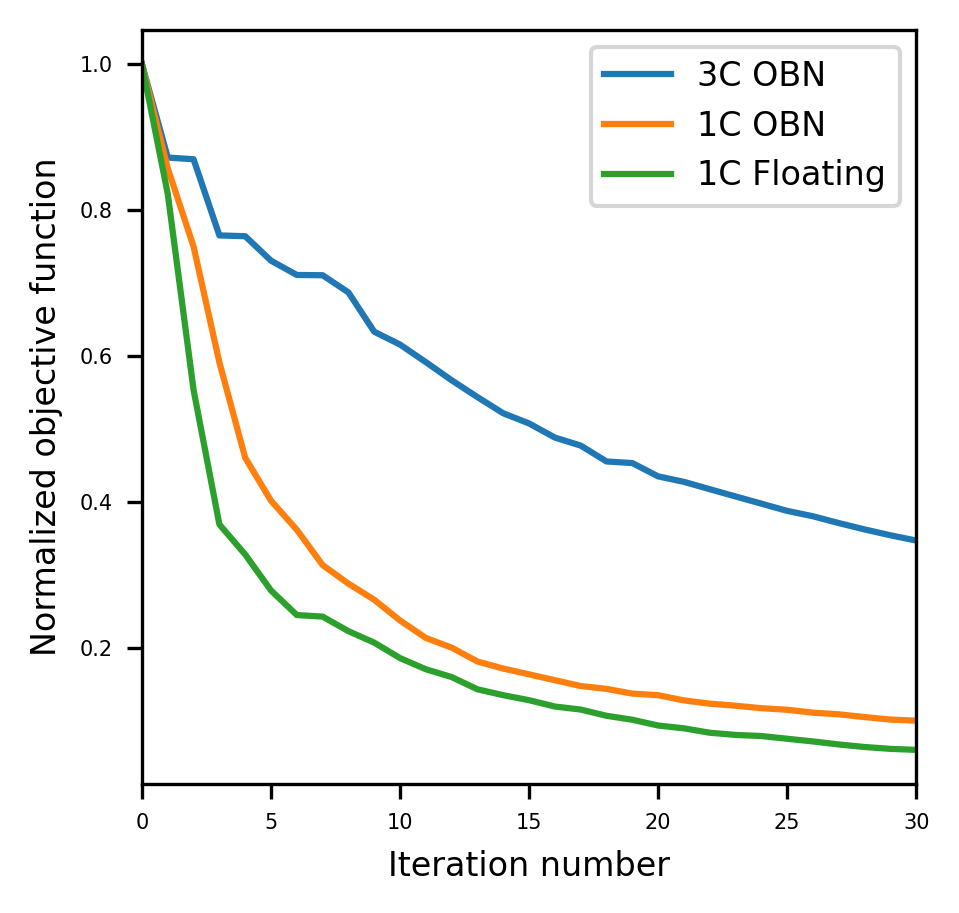

In [38]:
rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

plt.figure(figsize=(3.33,3.33),dpi=300)
plt.plot(func1/max(func1),label='3C OBN')
plt.plot(func2/max(func2),label='1C OBN')
plt.plot(func3/max(func3),label='1C Floating')
plt.xlabel("Iteration number",size=8)
plt.ylabel("Normalized objective function",size=8)
plt.xlim([0,30])
plt.gca().tick_params(axis='both', which='major', labelsize=5)
plt.legend()

#plt.show()
#plt.savefig('../fig/functional.png',bbox_inches='tight',format='png')